# Molecular translation

In [1]:
#!pip install efficientnet_pytorch

In [1]:
import re
import sys, time, os, gc
import cv2
import numba
from Levenshtein import distance
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import operator
from sklearn.model_selection import train_test_split 


import torch
import torchvision
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
import albumentations as T
import torch.nn as nn
from torchinfo import summary
from tqdm.notebook import tqdm


SEED = 117

np.random.seed(SEED)

In [2]:
# Para escoger la grafica en un server
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="7"

# Hiperparámetros

In [3]:
DATA_DIR= "bms-molecular-translation/"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SIZE = 224
MAX_LEN = 400
VOCAB_SIZE = 40
BATCH_SIZE = 128
WORKERS = 4
EPOCHS = 3

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Current device:", DEVICE.upper())

Current device: CUDA


# Cargamos los datos

In [4]:
df = pd.read_csv(DATA_DIR+"/train_labels.csv")
df.head()

image_id                                              InChI
0  000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1  000019cc0cd2  InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2  0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3  000026b49b7e  InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4  000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...

In [5]:
# El inicio del image_id es la ruta en las carpetas en donde se encuentra
df["img_path"] = df.image_id.apply(lambda x: os.path.join(TRAIN_DIR, x[0], x[1], x[2], x+".png"))
df.head()

image_id                                              InChI  \
0  000011a64c74  InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...   
1  000019cc0cd2  InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...   
2  0000252b6d2b  InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...   
3  000026b49b7e  InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...   
4  000026fc6c36  InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...   

                                            img_path  
0  bms-molecular-translation/train/0/0/0/000011a6...  
1  bms-molecular-translation/train/0/0/0/000019cc...  
2  bms-molecular-translation/train/0/0/0/0000252b...  
3  bms-molecular-translation/train/0/0/0/000026b4...  
4  bms-molecular-translation/train/0/0/0/000026fc...

In [6]:
control_sentence = ['<pad>', '<sos>', '<eos>']
prefixes = ['(', ')', '+', ',', '-', '=', '/b', '/c', '/h', '/i', '/m', '/s', '/t']
numbers = [str(x) for x in range(10)]
elements = ['B', 'Br', 'C', 'Cl', 'D', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si', 'T']
VOCAB = control_sentence+prefixes+numbers+elements


stoi = {b:n for n,b in enumerate(VOCAB)}# Diccionario con el mapeo del vocabulario a un valor numerico, para codificarlo
itos = {n:b for n,b in enumerate(VOCAB)}# Diccionario con el mapeo de los valores numericos al vocabulario que representa, para decodificarlo

print(f"Se tiene un vocabulario de tamaño: {len(VOCAB)}")

Se tiene un vocabulario de tamaño: 40


### Se observa los elementos mas frecuentes dentro del conjunto de entrenamiento

In [ ]:
# Se tokeniza la cadena y no se considera el inicio del formato (que viene siempre presente)
elem_frec = df["InChI"].str[9:].str.findall(r"([A-Z][a-z]?|[0-9]|\/[a-z]?|[\S])")

In [9]:
elem_frec

0          [C, 1, 3, H, 2, 0, O, S, /c, 1, -, 9, (, 2, ),...
1          [C, 2, 1, H, 3, 0, O, 4, /c, 1, -, 1, 2, (, 2,...
2          [C, 2, 4, H, 2, 3, N, 5, O, 4, /c, 1, -, 1, 4,...
3          [C, 1, 7, H, 2, 4, N, 2, O, 4, S, /c, 1, -, 1,...
4          [C, 1, 0, H, 1, 9, N, 3, O, 2, S, /c, 1, -, 1,...
                                 ...                        
2424181    [C, 1, 0, H, 1, 2, F, 2, N, 2, O, 3, /c, 1, -,...
2424182    [C, 1, 9, H, 2, 0, F, 2, N, 4, O, 3, S, /c, 1,...
2424183    [C, 2, 2, H, 2, 6, Cl, 2, N, 2, O, 4, S, /c, 1...
2424184    [C, 1, 7, H, 2, 6, N, 2, O, 6, S, /c, 1, -, 2,...
2424185    [C, 1, 0, H, 1, 8, N, 2, O, 9, P, 2, /c, 1, -,...
Name: InChI, Length: 2424186, dtype: object

In [10]:
# Calculamos diccionario de frecuencias
dicc_frec={}
for registro in elem_frec.values:
    for elemento in registro:
        if elemento not in numbers:
            dicc_frec[elemento]= dicc_frec.get(elemento,0)+1 

In [11]:
sort_dicc = sorted(dicc_frec.items(), key=operator.itemgetter(1),reverse=True)
x = [x[0] for x in sort_dicc]
freq =[x[1]for x in sort_dicc] 

Text(0, 0.5, 'Frecuencia')

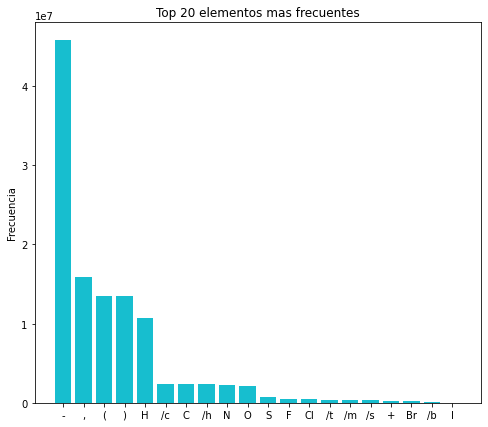

In [12]:
plt.figure(figsize=(8,7))
plt.bar(x[:20],freq[:20],color="tab:cyan")
plt.title("Top 20 elementos mas frecuentes")
plt.ylabel("Frecuencia")

In [13]:
del elem_frec

### Ahora graficamos la distribucion de la longitud de las etiquetas

Text(0.5, 6.79999999999999, 'Longitud')

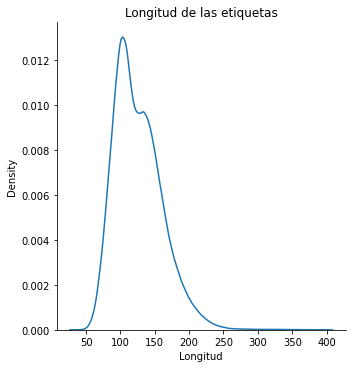

In [14]:
sns.displot(df["InChI"].str.len(),kind="kde")
plt.title("Longitud de las etiquetas")
plt.xlabel("Longitud")

Text(0.5, 0, 'Longitud')

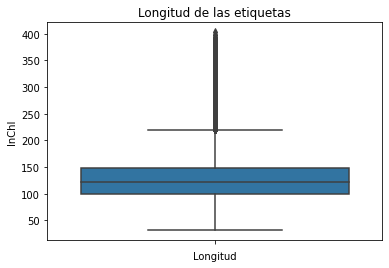

In [15]:
sns.boxplot(y=df["InChI"].str.len())
plt.title("Longitud de las etiquetas")
plt.xlabel("Longitud")

# Funciones auxiliares

In [7]:
def bms_collate(batch):
    images, labels = [], []
    for data in batch:
        images.append(data[0])
        labels.append(data[1])
    labels = pad_sequence(labels, batch_first = True, padding_value = 0) # 0 es el valor que representa el pad en el diccionario
    return torch.stack(images), labels

def generate_inchi(pred):
    label = [itos[i] for i in pred.to("cpu").numpy()]
    result = []
    for i in range(len(label)):
        if label[i] == "<eos>":
            break
        result.append(label[i])
    result = "InChI=1S/" + "".join(result)# Concatenamos el inicio de la cadena InChI con la prediccion
    return result

def levenshtein_score(y_pred, y):
    score = []
    for i in range(len(y)):
        a = generate_inchi(y_pred[i])
        b = generate_inchi(y[i])
        #print(a, b, sep='\n')
        score.append(distance(a, b))
    return score

# Dataloader

In [8]:
class Dataset():
    '''Carga las imagenes y las etiquetas en el formato para ser suministrado para el modelo'''
    
    def __init__(self, df, img_size=224, train=True,transform=None):
        self.df = df
        self.img_size = img_size
        self.is_train = train
        self.transform = transform
        self.images = self.df["img_path"].values
        self.inchi = self.df["InChI"].values
        self.inchi_pattern = r"([A-Z][a-z]?|[0-9]|\/[a-z]?|[\S])"
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        path = self.images[idx]
        #Leemos la imagen
        img = Image.open(path)
        img = img.convert('RGB')
        img = np.array(img)

        if self.transform is not None:
            img = self.transform(image=img)["image"]

        if self.is_train:
            inchi = self.inchi[idx]
            inchi = [stoi[s] for s in self.tokenize_inchi(inchi)]# Tokenizamos
            inchi.insert(0, stoi["<sos>"])# Agregamos etiqueta de inicio de oracion
            inchi.append(stoi["<eos>"]) # Agregamos etiqueta de fin de oracion
            inchi = torch.LongTensor(inchi)
            return img, inchi
        else:
            return img
    
    def tokenize_inchi(self, inchi):
        # Funcion para tokenizar las cadenas que se le suministren, sin considerar los primeros 9 caracteres
        #que corresponden con "InChI=1S/"
        return re.findall(self.inchi_pattern, inchi[9:])
    


In [9]:
# Transformaciones
trn_tsfm = T.Compose([
            T.Resize(IMG_SIZE, IMG_SIZE),
            T.HorizontalFlip(),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2()
        ])

tst_tsfm = T.Compose([
            T.Resize(IMG_SIZE, IMG_SIZE),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2()
        ])

In [10]:
df_train, df_valid = train_test_split(df, test_size = 0.1, random_state=0)
df_train, df_valid = df_train.reset_index(drop=True), df_valid.reset_index(drop=True)


train_data = Dataset(df_train,transform= trn_tsfm)
valid_data = Dataset(df_valid,transform= tst_tsfm)

train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True,
                          drop_last = True, collate_fn = bms_collate, num_workers = WORKERS)

valid_loader = DataLoader(valid_data, batch_size = BATCH_SIZE *2, shuffle = False, drop_last = False,
                          collate_fn = bms_collate, num_workers = WORKERS)
print("Train:", len(train_data))
print("Validation:", len(valid_data))

Train: 2181767
Validation: 242419


# Model

In [11]:
class CNN_LSTM(nn.Module):
    def __init__(self,vocab_size, embed_size, encoder_dim, decoder_dim,freeze=False):
        super().__init__()
        #Encoder CNN
        self.freeze=freeze
        self.resnet = torchvision.models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features

        if self.freeze:
            for params in self.resnet.parameters():
                params.requires_grad=False

            self.resnet.eval()

        self.resnet.fc = nn.Linear(num_ftrs, 256)

        #Decoder RNN
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.init_h = nn.Linear(in_features = encoder_dim, out_features = decoder_dim)
        self.init_c = nn.Linear(in_features = encoder_dim, out_features = decoder_dim)
        self.lstm = nn.LSTMCell(input_size = (embed_size + encoder_dim), hidden_size = decoder_dim, bias = True)
        self.drop = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = decoder_dim, out_features = vocab_size)
        self.features=None

    def forward(self, images,inchis):
        #Encoder
        batch_size = images.size(0)
        features = self.resnet(images)
        features = features.permute(0, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        self.features= features

        # Decoder
        embeds = self.embedding(inchis)
        features = features.mean(dim = 1)
        h = self.init_h(features)
        c = self.init_c(features)
        
        seq_length = len(inchis[0]) - 1 # para saber hasta donde predecimos, dejando lo restante como 0 que es el pad
        batch_size = inchis.size(0)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(DEVICE)
        
        for s in range(seq_length):
            lstm_input = torch.cat((embeds[:, s], features), dim = 1)
            h, c = self.lstm(lstm_input, (h, c))
            x = self.drop(h)
            x = self.linear(x)
            preds[:, s] = x
        return preds

    def predict(self, max_len):
        batch_size = self.features.size(0)
        features = self.features.mean(dim = 1)
        h = self.init_h(features)
        c = self.init_c(features)
        
        word = torch.full((batch_size, 1), stoi["<sos>"]).to(DEVICE)
        embeds = self.embedding(word)
        preds = torch.zeros((batch_size, max_len), dtype = torch.long).to(DEVICE)
        preds[:, 0] = word.squeeze()
        for i in range(max_len):
            lstm_input = torch.cat((embeds[:, 0], features), dim = 1)
            h, c = self.lstm(lstm_input, (h, c))
            x = self.drop(h)
            x = self.linear(x)
            x = x.view(batch_size, -1)
            pred_idx = x.argmax(dim = 1)
            preds[:, i] = pred_idx
            embeds = self.embedding(pred_idx).unsqueeze(1)
        return preds


In [12]:
model = CNN_LSTM(vocab_size = VOCAB_SIZE, embed_size = 256, encoder_dim = 256, decoder_dim = 512,freeze=False).to(DEVICE)

In [13]:
model

CNN_LSTM(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## Definimos los optimizadores y la funcion de perdida

In [18]:
model_optimizer = torch.optim.Adam(
    model.parameters(), lr = 1e-4, weight_decay = 1e-6, amsgrad = True)

model_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    model_optimizer, T_max = 4, eta_min = 1e-6, last_epoch = -1 )

criterion = nn.CrossEntropyLoss(ignore_index = 0)

## Train Loop

In [19]:
def train_fn(dl,model,model_optimizer):
    model.train()
    train_loss = 0
    for images, inchis in tqdm(dl):
        images = images.to(DEVICE)
        inchis = inchis.to(DEVICE)
        model_optimizer.zero_grad()
        #decoder_optimizer.zero_grad()
        preds = model(images,inchis)
        #preds = decoder(encoded, inchis)
        loss = criterion(preds.permute(0, 2, 1), inchis[:, 1:])
        train_loss += loss.item()
        loss.backward()
        model_optimizer.step()
    
    train_loss /= len(dl)
    return train_loss

In [20]:
def eval_fn(dl,model):
    model.eval()
    #decoder.eval()
    valid_loss = 0
    valid_levenshtein = []
    
    for images, inchis in tqdm(dl):
        images = images.to(DEVICE)
        inchis = inchis.to(DEVICE)
        with torch.no_grad():
            preds = model(images,inchis)
            #preds = decoder(encoded, inchis)
            loss = criterion(preds.permute(0, 2, 1), inchis[:, 1:])
            valid_loss += loss.item()
            
            pred_vals = model.predict(max_len = MAX_LEN)
            vd = levenshtein_score(pred_vals, inchis) #Levenshtein distance
            valid_levenshtein.append(np.mean(vd))
            
    valid_loss /= len(dl)
    valid_levenshtein = sum(valid_levenshtein) / len(valid_levenshtein)

    return valid_loss,valid_levenshtein

In [21]:
def train_model(model, model_optimizer,name):
    best_loss = np.inf
    train_losses = []
    valid_losses = []

    for epoch in range(EPOCHS):
        print(f"Epoca [{epoch+1}/{EPOCHS}]:")
        train_loss =train_fn(train_loader, model,model_optimizer)

        valid_loss, valid_levenshtein =eval_fn(valid_loader,model)
        print(f"[epoca {epoch+1}/{EPOCHS}] loss: {valid_loss}")
        print(f"[epoca {epoch+1}/{EPOCHS}] Lavenshtein: {valid_levenshtein}")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), name)
            print("Modelo guardado...")
        else:
            print("No se mejoró la pérdida...")

    return train_losses,valid_losses

In [13]:
#train_losses, valid_losses = train_model(model,model_optimizer,"cnn-unfrozeen-lstm.pth")

In [19]:
# plt.figure(figsize=(10,7))
# plt.plot(range(EPOCHS),train_losses,color="turquoise",label="Pérdida train")
# plt.plot(range(EPOCHS),valid_losses,color="lightcoral",label="Pérdida test")
# plt.legend()

In [29]:
#train_losses, valid_losses = train_model(model,model_optimizer,"prueba.pth")

# Probamos congelando la CNN

In [30]:
model = CNN_LSTM(vocab_size = VOCAB_SIZE, embed_size = 256, encoder_dim = 256, decoder_dim = 512,freeze=True).to(DEVICE)

In [17]:
model_optimizer = torch.optim.Adam(
    model.parameters(), lr = 1e-4, weight_decay = 1e-6, amsgrad = True)

model_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    model_optimizer, T_max = 4, eta_min = 1e-6, last_epoch = -1 )

criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [23]:
train_losses, valid_losses = train_model(model,model_optimizer,"cnn-frozen-lstm.pth")

Epoca [1/3]:


  0%|          | 0/17045 [00:00<?, ?it/s]

  0%|          | 0/947 [00:00<?, ?it/s]

[epoca 1/3] loss: 0.738775065103831
[epoca 1/3] Lavenshtein: 76.59067359535852
Modelo guardado...
Epoca [2/3]:


  0%|          | 0/17045 [00:00<?, ?it/s]

  0%|          | 0/947 [00:00<?, ?it/s]

[epoca 2/3] loss: 0.6515166033787108
[epoca 2/3] Lavenshtein: 75.58601179854837
Modelo guardado...
Epoca [3/3]:


  0%|          | 0/17045 [00:00<?, ?it/s]

  0%|          | 0/947 [00:00<?, ?it/s]

[epoca 3/3] loss: 0.6120843930128635
[epoca 3/3] Lavenshtein: 75.80143888636304
Modelo guardado...


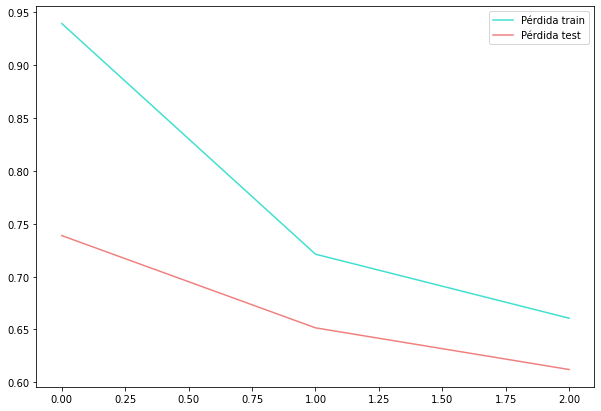

In [24]:
plt.figure(figsize=(10,7))
plt.plot(range(EPOCHS),train_losses,color="turquoise",label="Pérdida train")
plt.plot(range(EPOCHS),valid_losses,color="lightcoral",label="Pérdida test")
plt.legend()

# Probamos con efficent net

In [22]:
class CNN_EffNET_LSTM(nn.Module):
    def __init__(self,vocab_size, embed_size, encoder_dim, decoder_dim,freeze=False):
        super().__init__()
        #Encoder CNN
        self.freeze = freeze
        self.effnet = EfficientNet.from_name('efficientnet-b0')

        num_ftrs = self.effnet._fc.in_features
        
        if self.freeze:
            for params in self.effnet.parameters():
                params.requires_grad=False

            self.effnet.eval()

        self.effnet._fc = nn.Linear(num_ftrs, 256)
        self.effnet = self.effnet.to(DEVICE)

        #Decoder RNN
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.init_h = nn.Linear(in_features = encoder_dim, out_features = decoder_dim)
        self.init_c = nn.Linear(in_features = encoder_dim, out_features = decoder_dim)
        self.lstm = nn.LSTMCell(input_size = (embed_size + encoder_dim), hidden_size = decoder_dim, bias = True)
        self.drop = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = decoder_dim, out_features = vocab_size)
        self.features=None

    def forward(self, images,inchis):
        #Encoder
        batch_size = images.size(0)
        features = self.effnet(images)
        features = features.permute(0, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        self.features= features

        # Decoder
        embeds = self.embedding(inchis)
        features = features.mean(dim = 1)
        h = self.init_h(features)
        c = self.init_c(features)
        
        seq_length = len(inchis[0]) - 1
        batch_size = inchis.size(0)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(DEVICE)
        
        for s in range(seq_length):
            lstm_input = torch.cat((embeds[:, s], features), dim = 1)
            h, c = self.lstm(lstm_input, (h, c))
            x = self.drop(h)
            x = self.linear(x)
            preds[:, s] = x
        return preds

    def predict(self, max_len):
        batch_size = self.features.size(0)
        features = self.features.mean(dim = 1)
        h = self.init_h(features)
        c = self.init_c(features)
        
        word = torch.full((batch_size, 1), stoi["<sos>"]).to(DEVICE)
        embeds = self.embedding(word)
        preds = torch.zeros((batch_size, max_len), dtype = torch.long).to(DEVICE)
        preds[:, 0] = word.squeeze()
        for i in range(max_len):
            lstm_input = torch.cat((embeds[:, 0], features), dim = 1)
            h, c = self.lstm(lstm_input, (h, c))
            x = self.drop(h)
            x = self.linear(x)
            x = x.view(batch_size, -1)
            pred_idx = x.argmax(dim = 1)
            preds[:, i] = pred_idx
            embeds = self.embedding(pred_idx).unsqueeze(1)
        return preds


In [23]:
model = CNN_EffNET_LSTM(vocab_size = VOCAB_SIZE, embed_size = 256, encoder_dim = 256, decoder_dim = 512,freeze=True).to(DEVICE)

In [24]:
model_optimizer = torch.optim.Adam(
    model.parameters(), lr = 1e-4, weight_decay = 1e-6, amsgrad = True)

model_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    model_optimizer, T_max = 4, eta_min = 1e-6, last_epoch = -1 )

criterion = nn.CrossEntropyLoss(ignore_index = 0)

In [23]:
#train_losses, valid_losses = train_model(model,model_optimizer,"cnn-eff-lstm.pth")

# Evaluacion

### Modelo 1

In [18]:
model_params ="cnn-unfrozeen-lstm.pth"
model = CNN_LSTM(vocab_size = VOCAB_SIZE, embed_size = 256, encoder_dim = 256, decoder_dim = 512,freeze=False).to(DEVICE)
model.load_state_dict(torch.load(model_params, map_location = DEVICE))
valid_loss, valid_levenshtein =eval_fn(valid_loader,model)
print(f"El modelo 1 tiene una perdida de :{valid_loss}, perdida levenshtein: {valid_levenshtein}")

  0%|          | 0/947 [00:00<?, ?it/s]

El modelo 1 tiene una perdida de :0.3644313128722129, perdida levenshtein: 48.78071050800448


In [20]:
del model

### Modelo 2 

In [21]:
model_params ="cnn-frozen-lstm.pth"
model = CNN_LSTM(vocab_size = VOCAB_SIZE, embed_size = 256, encoder_dim = 256, decoder_dim = 512,freeze=True).to(DEVICE)
model.load_state_dict(torch.load(model_params, map_location = DEVICE))
valid_loss, valid_levenshtein =eval_fn(valid_loader,model)
print(f"El modelo 2 tiene una perdida de :{valid_loss}, perdida levenshtein: {valid_levenshtein}")

  0%|          | 0/947 [00:00<?, ?it/s]

El modelo 2 tiene una perdida de :0.6120843948381378, perdida levenshtein: 75.80143888636304


In [22]:
del model

### Modelo 3

In [25]:
model_params ="cnn-eff-lstm.pth"
model = CNN_EffNET_LSTM(vocab_size = VOCAB_SIZE, embed_size = 256, encoder_dim = 256, decoder_dim = 512,freeze=True).to(DEVICE)
model.load_state_dict(torch.load(model_params, map_location = DEVICE))
valid_loss, valid_levenshtein =eval_fn(valid_loader,model)
print(f"El modelo 3 tiene una perdida de :{valid_loss}, perdida levenshtein: {valid_levenshtein}")

  0%|          | 0/947 [00:00<?, ?it/s]

El modelo 3 tiene una perdida de :0.645521038940615, perdida levenshtein: 79.93010480763381
